# Using nearest neighbor OCR data to expand tag sets

In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Getting pool3 scores

In [2]:
def create_graph(pb_file):
    """"Creates a graph from saved GraphDef file and returns a Graph object.
    Returns:
    Graph holding the trained Inception network.
    """
    model_filename = pb_file
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [4]:
#create_graph("/data/retrain_manualtags1/output_graphfinal.pb")
create_graph("/data/classify_image_graph_def.pb")
sess = tf.Session()

In [5]:
params = pickle.load(open("/data/10k_aug_outputs/output_params_lr1e-3_adam9800.pkl", 'r'))
fw = params["final_weights"]
fb = params["final_biases"]
print fb.shape
print fw.shape

(12,)
(2048, 12)


In [2]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [3]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [20]:
image_metadata[43000]

['001760870_01_000259_1_', '1833', 'p', 'people']

Here we choose 1000 random images that are tagged as animals

In [3]:
ctr = 0
indices = []  # list of indices of images that represent animals
#while ctr < 1000:
#    idx = np.random.randint(0, 970218)
for idx in xrange(970218):
    if image_metadata[idx][-1] != 'animals': continue  # skip non-animal images
    ctr += 1
    indices.append(idx)

In [9]:
idx_to_pool3_scores = {}
pool3_tensor = sess.graph.get_tensor_by_name('pool_3:0')

ctr = 0
for idx in indices:
    ctr += 1
    if ctr % 500 == 0: print ctr
    if ctr % 5000 == 0: 
        pickle.dump(idx_to_pool3_scores, open("/data/nearest_neighbor_tagging/pool3_softmax_scores_animals_{}.pkl".format(ctr), 'w'))
        idx_to_pool3_scores = {}
    chk = idx/5000
    chunk = "Chunk" + str(chk)
    i = idx % 5000
    if chunk not in image_hdf5: continue

    a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
    predictions = sess.run(pool3_tensor, {'ExpandDims:0': a})[:,0,0,:]
    idx_to_pool3_scores[idx] = predictions[0]

pickle.dump(idx_to_pool3_scores, open("/data/nearest_neighbor_tagging/pool3_softmax_scores_animals_{}.pkl".format(ctr), 'w'))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000


## Obtain noun phrases

In [4]:
ocr_hdf5 = h5py.File('/data/ocr_data.hdf5','r')

In [5]:
# coding=UTF-8
import nltk
from nltk.corpus import brown

# This is a fast and simple noun phrase extractor (based on NLTK)
# Feel free to use it, just keep a link back to this post
# http://thetokenizer.com/2013/05/09/efficient-way-to-extract-the-main-topics-of-a-sentence/
# Create by Shlomi Babluki
# May, 2013

# This is our fast Part of Speech tagger
#############################################################################
brown_train = brown.tagged_sents(categories='news')
regexp_tagger = nltk.RegexpTagger(
    [(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),
     (r'(-|:|;)$', ':'),
     (r'\'*$', 'MD'),
     (r'(The|the|A|a|An|an)$', 'AT'),
     (r'.*able$', 'JJ'),
     (r'^[A-Z].*$', 'NNP'),
     (r'.*ness$', 'NN'),
     (r'.*ly$', 'RB'),
     (r'.*s$', 'NNS'),
     (r'.*ing$', 'VBG'),
     (r'.*ed$', 'VBD'),
     (r'.*', 'NN')
])
unigram_tagger = nltk.UnigramTagger(brown_train, backoff=regexp_tagger)
bigram_tagger = nltk.BigramTagger(brown_train, backoff=unigram_tagger)
#############################################################################


# This is our semi-CFG; Extend it according to your own needs
#############################################################################
cfg = {}
cfg["NNP+NNP"] = "NNP"
cfg["NN+NN"] = "NNI"
cfg["NNI+NN"] = "NNI"
cfg["JJ+JJ"] = "JJ"
cfg["JJ+NN"] = "NNI"
#############################################################################


class NPExtractor(object):

    def __init__(self, sentence):
        self.sentence = sentence

    # Split the sentence into singlw words/tokens
    def tokenize_sentence(self, sentence):
        tokens = nltk.word_tokenize(sentence)
        return tokens

    # Normalize brown corpus' tags ("NN", "NN-PL", "NNS" > "NN")
    def normalize_tags(self, tagged):
        n_tagged = []
        for t in tagged:
            if t[1] == "NP-TL" or t[1] == "NP":
                n_tagged.append((t[0], "NNP"))
                continue
            if t[1].endswith("-TL"):
                n_tagged.append((t[0], t[1][:-3]))
                continue
            if t[1].endswith("S"):
                n_tagged.append((t[0], t[1][:-1]))
                continue
            n_tagged.append((t[0], t[1]))
        return n_tagged

    # Extract the main topics from the sentence
    def extract(self):

        tokens = self.tokenize_sentence(self.sentence)
        tags = self.normalize_tags(bigram_tagger.tag(tokens))

        merge = True
        while merge:
            merge = False
            for x in range(0, len(tags) - 1):
                t1 = tags[x]
                t2 = tags[x + 1]
                key = "%s+%s" % (t1[1], t2[1])
                value = cfg.get(key, '')
                if value:
                    merge = True
                    tags.pop(x)
                    tags.pop(x)
                    match = "%s %s" % (t1[0], t2[0])
                    pos = value
                    tags.insert(x, (match, pos))
                    break

        matches = []
        for t in tags:
            if t[1] == "NNP" or t[1] == "NNI":
            #if t[1] == "NNP" or t[1] == "NNI" or t[1] == "NN":
                matches.append(t[0])
        return matches

In [6]:
def get_noun_phrases_from_img(chunk, img):
    chunk = int(chunk)
    img = int(img)
    
    phrase = ' '.join(ocr_hdf5['Chunk{}'.format(chunk)][img][1:]).decode("ascii", errors="ignore")
    np_extractor = NPExtractor(phrase)
    multiword_res = [x.lower() for x in np_extractor.extract()]
    
    res = []
    for word in multiword_res:
        res.extend(word.split(' '))
        
    # number of items in the set divided by total length; a marker of English or not-English
    pct_np = float(len(set(res)))/len(phrase)
    
    # get the words that appear most often
    #print Counter(res).most_common(10)

    return pct_np, res

def get_noun_phrases_from_text(txt):
    np_extractor = NPExtractor(txt)
    multiword_res = [x.lower() for x in np_extractor.extract()]
    
    res = []
    for word in multiword_res:
        res.extend(word.split(' '))
    
    res = [x for x in res if len(x) > 3]
    return res

In [13]:
idx_to_noun_phrases = {}
for idx in indices:
    chk = idx/5000
    i = idx % 5000
    pct_np, res = get_noun_phrases_from_img(chk, i)
    idx_to_noun_phrases[idx] = set(res)

In [14]:
pickle.dump(idx_to_noun_phrases, open("/data/nearest_neighbor_tagging/idx_to_noun_phrases_animals.pkl", 'w'))

## Reduce dimensionality of scores

In [7]:
import glob
res = {}
pkl_files = glob.glob("/data/nearest_neighbor_tagging/pool3_softmax_scores_animals_*.pkl")
for pkl in pkl_files:
    res.update(pickle.load(open(pkl, 'r')))

In [8]:
pool3_arr = []
for idx in indices:
    pool3_arr.append(res[idx])
pool3_arr = np.array(pool3_arr)
pool3_arr.shape

(56220, 2048)

In [34]:
#pool3_df = pd.DataFrame.from_dict(idx_to_pool3_scores)  # each image vector is a column
#pool3_df.shape

(2048, 993)

In [74]:
#pool3_arr = np.array(pool3_df).T
#pool3_arr.shape

(993, 2048)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40, whiten=True)
%time pool3_pca = pca.fit(pool3_arr)

CPU times: user 2min 1s, sys: 367 ms, total: 2min 1s
Wall time: 2min 1s


In [10]:
%time pool3_pca_scores = pool3_pca.transform(pool3_arr)

CPU times: user 20.9 s, sys: 108 ms, total: 21 s
Wall time: 21 s


In [11]:
pool3_pca_scores.shape

(56220, 40)

In [55]:
pickle.dump((pool3_arr, pool3_pca_scores), open("/data/nearest_neighbor_tagging/pool3_animals_pca.pkl", 'w'))

## All scores

In [143]:
scores_data = h5py.File('/data/all_scores_12class.hdf5','w')

In [144]:
for i in range(200):  # looping over each pickle
    if i % 20 == 0: print i
    try:
        chunk_file = "/data/1M_tags/Chunk{}.pkl".format(i)
        scores = pickle.load(open(chunk_file, 'r'))    
    except:
        continue
    temp = np.empty((5000,12))
    for index in range(5000):
        if index not in scores: continue
        temp[index] = scores[index]
    scores_data.create_dataset("Chunk{}".format(i), data=temp)

scores_data.close()

0
20
40
60
80
100
120
140
160
180


In [12]:
scores_data = h5py.File('/data/all_scores_12class.hdf5','r')
scores_data["Chunk1"][400]

array([  3.11982818e-02,   8.32416627e-05,   5.60833097e-01,
         2.79666303e-04,   8.79068300e-02,   4.45149913e-02,
         1.96852779e-04,   6.89041018e-02,   5.22559458e-05,
         2.01110378e-01,   3.77605017e-03,   1.14434422e-03])

In [13]:
animal_scores = []
for idx in indices:
    chk = idx/5000
    i = idx % 5000
    animal_scores.append(scores_data["Chunk{}".format(chk)][i][0])

In [14]:
scores_data.close()

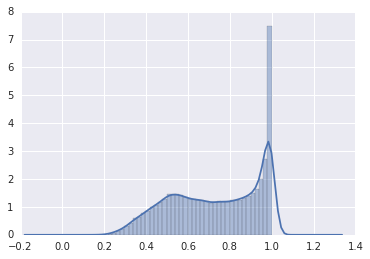

In [15]:
sns.distplot(animal_scores)

In [16]:
animal_scores = np.array(animal_scores)
np.sum(animal_scores>0.9)

17299

In [17]:
(animal_scores>0.9)[:10]

array([False,  True, False, False, False, False,  True, False, False, False], dtype=bool)

## Calculate similarity neighborhoods for each image

In [18]:
pool3_pca_scores = np.array(pool3_pca_scores)
pool3_pca_scores_trunc = pool3_pca_scores[(animal_scores>0.9),:]
pool3_pca_scores_trunc.shape

(17299, 40)

In [19]:
from sklearn.metrics.pairwise import pairwise_distances
%time dist = pairwise_distances(pool3_pca_scores_trunc, n_jobs=-1)
dist.shape

CPU times: user 1.98 s, sys: 1.33 s, total: 3.32 s
Wall time: 8.89 s


(17299, 17299)

In [30]:
indices = np.array(indices)
indices_trunc = indices[animal_scores>0.9]

In [35]:
indices_trunc[10000:10010]

array([536678, 536739, 537005, 537072, 537096, 537107, 537343, 537426,
       537597, 537694])

In [39]:
idx_to_neighbors = {}
for i in range(dist.shape[0]):
    if i % 2000 == 0: print i
    idx = indices_trunc[i]

    neighbor_ranks = np.array(dist[i,:]).argsort()  # returns a list of the column indices in order from smallest to largest
    idx_to_neighbors[indices_trunc[i]] = [(indices_trunc[z], dist[i,z]) for z in neighbor_ranks[:20]]  # skip the first one (distance = 0)

0
2000
4000
6000
8000
10000
12000
14000
16000


In [156]:
# calculate distance one at a time if the matrix is too large

# idx_to_neighbors = {}
# for i in range(pool3_pca_scores_90pct.shape[0]):
#     if i % 500 == 0: print i
#     dists = []
#     for j in range(pool3_pca_scores_90pct.shape[0]):
#         dists.append(np.linalg.norm(pool3_pca_scores_90pct[i,:]-pool3_pca_scores_90pct[j,:]))

#     neighbor_ranks = np.array(dists).argsort()  # returns a list of the column indices in order from smallest to largest
#     idx_to_neighbors[indices[i]] = [(indices[z], dists[z]) for z in neighbor_ranks[:20]]  # skip the first one (distance = 0)

0


KeyboardInterrupt: 

In [40]:
idx_to_neighbors.items()[:20]

[(884736,
  [(884736, 0.0),
   (645778, 3.7124333),
   (80793, 3.8042459),
   (710182, 4.2788916),
   (315346, 4.3147759),
   (686023, 4.346312),
   (396585, 4.3861289),
   (138365, 4.4119916),
   (503130, 4.4159999),
   (431255, 4.4429622),
   (236185, 4.4977322),
   (433309, 4.5180869),
   (482790, 4.5336628),
   (144239, 4.5487571),
   (713864, 4.5644608),
   (591786, 4.5872469),
   (890176, 4.6024256),
   (236893, 4.6183376),
   (251407, 4.6231594),
   (269918, 4.6335554)]),
 (393218,
  [(393218, 0.0),
   (616611, 4.7709064),
   (429496, 4.8603897),
   (761940, 4.8977704),
   (287439, 4.9463224),
   (69660, 5.0266285),
   (135586, 5.0453424),
   (620623, 5.0900259),
   (892512, 5.0981765),
   (756223, 5.2388992),
   (373475, 5.2475033),
   (496071, 5.2707219),
   (18166, 5.2932377),
   (122630, 5.3101692),
   (569406, 5.3154836),
   (729440, 5.3529453),
   (121988, 5.3616586),
   (822419, 5.3738427),
   (128305, 5.4241753),
   (666836, 5.425746)]),
 (458756,
  [(458756, 0.0),
   (8

In [4]:
def si(idx):
    chk = idx/5000
    i = idx % 5000
    plt.imshow(to_rgb(image_hdf5['Chunk{}'.format(chk)][i][:,:,0]), cmap=mpl.cm.gray) 

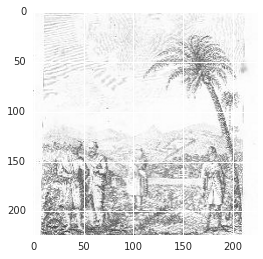

In [32]:
si(17204)

In [54]:
idx_to_noun_phrases = pickle.load(open("/data/nearest_neighbor_tagging/idx_to_noun_phrases_animals.pkl", 'r'))

In [72]:
all_words = []
all_words.extend(idx_to_noun_phrases[294917])
for item in idx_to_neighbors[294917]:
    all_words.extend(idx_to_noun_phrases[item[0]])

In [80]:
list([str(x) for x in idx_to_noun_phrases[294917]])

['upper',
 'soc',
 'gr',
 'plate',
 'rufous',
 'b.',
 'fuscous',
 'feathers',
 'paeif',
 'surface',
 'neous',
 'rusty',
 'boitnp',
 'female',
 'cruise',
 'myiagra',
 'pale',
 'id',
 'contents',
 'lakno',
 'trop',
 'outer',
 'aud',
 'm.',
 'rev',
 'lava',
 'the',
 'tail',
 'fig',
 'hebrides',
 'ocean',
 'feather',
 'specimens',
 'g.',
 'viii',
 'caledonica',
 'brown',
 'eyes',
 'spicillata',
 'slate',
 'dark',
 'breast',
 'i.',
 'vanua',
 'caledonia',
 'wings',
 'greyish',
 'proc',
 'colour',
 'melanura',
 'zool',
 'j.',
 'per-',
 'cat',
 'p',
 'length',
 'obscure',
 'of',
 'r.',
 'homb']

In [77]:
from collections import Counter
Counter(all_words).most_common(30)

[(u'of', 11),
 (u'the', 9),
 (u'plate', 7),
 (u'feathers', 6),
 (u"'s", 6),
 (u'brown', 6),
 (u'upper', 6),
 (u'dark', 6),
 (u'rufous', 6),
 (u'outer', 6),
 (u'birds', 5),
 (u'tail', 5),
 (u'g.', 5),
 (u'length', 5),
 (u'wings', 4),
 (u'black', 4),
 (u'large', 4),
 (u'small', 4),
 (u'pale', 4),
 (u'bird', 4),
 (u'cruise', 4),
 (u'feather', 4),
 (u'>', 4),
 (u'colour', 4),
 (u'female', 4),
 (u'specimens', 4),
 (u'aud', 3),
 (u'rusty', 3),
 (u'blue', 3),
 (u'dry', 3)]